This file is part of a program that is used to develop an objective way to
segment the fetus from ultrasound images, and to analyse the effectiveness of 
using the resulting mask to produce an unobstructed visualisation of the fetus.
The research is organised in three phases: (1) noise reduction filters, 
(2a) heuristic segmentation models, (2b) deep learning segmentation
approach (U-net), and (3) the volume visualisation. The program is developed
for the master Computational Science at the UvA from February to November 2020.

This file contains code for the volume visualisation. <br>
You can run this file to convert the data.  

Made by Romy Meester


In [1]:
"""
Phase 3: The volume visualisations.
- VTK (DICOM, numpy arrays)
- Volume viewer (.vti -- or .vtk and convert it manually in VolView to .vti)
- Exposure render (.mhd)
"""

import os
import numpy as np
import SimpleITK as sitk
import pickle
import copy
import time
import matplotlib.pyplot as plt

from tqdm import tqdm


In [2]:
# Constants
RESULTS_PATH = 'results_volumes'
RESULTS_CONVERT_PATH = os.path.join(RESULTS_PATH, 'results_volumes_convert')
RESULTS_VIS_PATH = os.path.join(RESULTS_PATH, 'results_volumes_visualisations')

RESULTS_ORG_PATH = os.path.join(RESULTS_CONVERT_PATH, 'convert_original') 
RESULTS_SMOOTHED_PATH = os.path.join(RESULTS_CONVERT_PATH, 'convert_smoothed') 
RESULTS_GT_PATH = os.path.join(RESULTS_CONVERT_PATH, 'convert_groundtruth')
RESULTS_HEURISTICS_PATH = os.path.join(RESULTS_CONVERT_PATH, 'convert_heuristics')
RESULTS_UNET_PATH = os.path.join(RESULTS_CONVERT_PATH, 'convert_unet')

DATA_ORG_PATH = '../datasets/'
DATA_SMOOTH_PATH = '../phase1/results_filters/results_filters_img'
DATA_HEUR_PATH = '../phase2a/results_heuristic_models/results_heuristics_img'
DATA_UNET_PATH = '../phase2b/results_unet/results_unet_model'

In [3]:
def create_dir(PATH):
    """ Create a directory. """
    try:
        os.mkdir(PATH)
        print('Directory', PATH, 'created' )
    except FileExistsError:
        print('Directory', PATH, 'already exists' )

        
# create results folder
create_dir(RESULTS_PATH)  
        
# create results folder for the converted data and the visualisations
create_dir(RESULTS_CONVERT_PATH)
create_dir(RESULTS_VIS_PATH)

# create results folders
create_dir(RESULTS_ORG_PATH)
create_dir(RESULTS_SMOOTHED_PATH)
create_dir(RESULTS_GT_PATH)
create_dir(RESULTS_HEURISTICS_PATH)
create_dir(RESULTS_UNET_PATH)

Directory results_volumes already exists
Directory results_volumes\results_volumes_convert created
Directory results_volumes\results_volumes_visualisations already exists
Directory results_volumes\results_volumes_convert\convert_original created
Directory results_volumes\results_volumes_convert\convert_smoothed created
Directory results_volumes\results_volumes_convert\convert_groundtruth created
Directory results_volumes\results_volumes_convert\convert_heuristics created
Directory results_volumes\results_volumes_convert\convert_unet created


In [4]:
#create in each directory two other folders 
folders = [f for f in os.listdir(RESULTS_CONVERT_PATH) if os.path.isdir(os.path.join(RESULTS_CONVERT_PATH, f))]

for folder in folders: 
    to_folder = os.path.join(RESULTS_CONVERT_PATH, folder) 
    RESULTS_VOLUMEVIEWER = os.path.join(to_folder, 'volume_viewer')
    RESULTS_EXPOSURERENDER = os.path.join(to_folder, 'exposure_render')
    
    create_dir(RESULTS_VOLUMEVIEWER)
    create_dir(RESULTS_EXPOSURERENDER)

Directory results_volumes\results_volumes_convert\convert_groundtruth\volume_viewer created
Directory results_volumes\results_volumes_convert\convert_groundtruth\exposure_render created
Directory results_volumes\results_volumes_convert\convert_heuristics\volume_viewer created
Directory results_volumes\results_volumes_convert\convert_heuristics\exposure_render created
Directory results_volumes\results_volumes_convert\convert_original\volume_viewer created
Directory results_volumes\results_volumes_convert\convert_original\exposure_render created
Directory results_volumes\results_volumes_convert\convert_smoothed\volume_viewer created
Directory results_volumes\results_volumes_convert\convert_smoothed\exposure_render created
Directory results_volumes\results_volumes_convert\convert_unet\volume_viewer created
Directory results_volumes\results_volumes_convert\convert_unet\exposure_render created


# Original images

In [5]:
def load_scans(pathDicom):
    """ Load the dicom files into sitk with the image series reader.
    Input: path of the directory with the dicom files.
    Output: the 3D image.
    """
    
    reader = sitk.ImageSeriesReader()
    filenamesDICOM = reader.GetGDCMSeriesFileNames(pathDicom)
    reader.SetFileNames(filenamesDICOM)
    img = reader.Execute()
    return img

In [6]:
def get_data_dcm(rootdir, scans = 'org'):
    """ Generate the dataset of dcm files in a dictionary. """
    
    datasets = {}
    
    # the folders
    datasetnames = [f for f in os.listdir(rootdir) if os.path.isdir(os.path.join(rootdir, f))]
    print('Loading: ' + str(len(datasetnames)) + ' datasets')
    
    # which scans
    if scans == 'org':
        scan = '/crop_org'
    elif scans == 'gt':
        scan = '/crop_gt'
    
    # load scans to numpy
    for dataset in tqdm(datasetnames):
        time.sleep(0.1)
        
        images = load_scans(rootdir + dataset + scan) 
        images = sitk.GetArrayFromImage(images)
        
        # Save images in datasets dictionary
        datasets.update({dataset: images})

    print("datasets created")
    return datasets
    

In [7]:
# the original images in numpy arrays
org_images = get_data_dcm(DATA_ORG_PATH, scans ='org')

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Loading: 7 datasets


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.08s/it]

datasets created


In [8]:
def convert_mhd(datasets, savedir):
    """ Save the numpy images to .mhd file for exposure render. """
    
    print('Convert ' + str(len(datasets)) + ' datasets')
    for datakey, values in datasets.items():
        # convert numpy array to sitk image
        image =  sitk.GetImageFromArray(values)
        
        # write the file
        writer = sitk.ImageFileWriter()
        writer.SetFileName(savedir + '/' + 'exposure_render/' +  datakey + '.mhd')
        writer.Execute(image)

convert_mhd(datasets = org_images, savedir = RESULTS_ORG_PATH)

Convert 7 datasets


# Smoothed images

In [9]:
def load_data_smoothed_pickle(PATH, filename):
    """ Load data from file using pickle. """
    with open(PATH + '/' + filename + ".pkl","rb") as f:
        new_data = pickle.load(f)
    return new_data

def get_data_smoothedimages(rootdir, filterdata):
    """ Get the data of the specified smoothed images. """
    
    datasets = {}
        
    # the files
    alldatasetnames = [f for f in os.listdir(rootdir) if os.path.isfile(os.path.join(rootdir, f))]
    datasetnames = []
    for name in alldatasetnames:
        if filterdata['filtername'] and str(filterdata['parameters'][0]) in name:
            try: 
                if str(filterdata['parameters'][0]) and str(filterdata['parameters'][1])  in name:
                    datasetnames.append(name[:-4])
            except:
                datasetnames.append(name[:-4])
    
    # load scans to numpy
    print('Loading: ' + str(len(datasetnames)) + ' datasets')
    for dataset in tqdm(datasetnames):
        time.sleep(0.1)
        
        images_smoothed = load_data_smoothed_pickle(rootdir, dataset) 
      
        # Save images in datasets dictionary
        datasetname = dataset.split('_', 1)[0]
        datasets.update({datasetname: images_smoothed})

    print("datasets created")
    return datasets


In [10]:
# the smoothed images in numpy arrays
filterdata = {'filtername': 'anisodiff', 'parameters': [10, 0.04, 4]}
smoothed_images = get_data_smoothedimages(DATA_SMOOTH_PATH, filterdata)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Loading: 7 datasets


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.27it/s]

datasets created


In [11]:
def convert_vtk(datasets, savedir):
    """ Save the numpy images to .vtk file for eventually showing in volume viewer.
        Additionally, the files are in Volview manually saved as a .vti file.
        This .vti file can be read in volume viewer. """

    print('Convert ' + str(len(datasets)) + ' datasets')
    for datakey, values in datasets.items():
        # convert numpy array to sitk image
        image =  sitk.GetImageFromArray(values)
        
        # write the file
        writer = sitk.ImageFileWriter()
        writer.SetFileName(savedir + '/' + 'volume_viewer/' +  datakey + '.vtk')
        writer.Execute(image)


In [12]:
# convert the smoothed original image as mhd and vtk files
# (the original image and ground truth image do not need to be converted to vtk files, 
# since these DICOM files can be opened directly in VolView)
convert_mhd(datasets = smoothed_images, savedir = RESULTS_SMOOTHED_PATH)
convert_vtk(datasets = smoothed_images, savedir = RESULTS_SMOOTHED_PATH)

Convert 7 datasets
Convert 7 datasets


In [13]:
def save_data_smooth_pickle(PATH, data, filename):
    """ Save the data of the smoothed images in pickle file. """
    with open(PATH + '/' + filename + ".pkl","wb") as f:
        pickle.dump(data,f)
    print(filename, "created")

In [14]:
# save the data in numpy arrays (pickle files) for VTK
save_data_smooth_pickle(PATH = RESULTS_SMOOTHED_PATH, data = smoothed_images, filename = 'smoothed_images')

smoothed_images created


# Ground truth

In [15]:
# get the ground truth images
gt_images = get_data_dcm(DATA_ORG_PATH, scans ='gt')

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Loading: 7 datasets


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.59it/s]

datasets created


In [16]:
# convert the (inverted mask) ground truth over the original image     
def apply_mask(frame_org, frame_mask):
    """ Apply a mask over the original image. """
    frame_result = copy.copy(frame_org)
    frame_result[frame_mask == 0] = 0

    return frame_result

def generate_invmask(org_datasets, binary_datasets):
    """ Generate the inverted masks. 
        Apply the binary mask over the original image to create an inverted mask. """
    
    inv_datasets = {}
 
    # apply the masks over the original images
    for binary_key, binary_image in binary_datasets.items():
        dataset_key = binary_key.split('_', 1)[0]
        image = apply_mask(org_datasets[dataset_key], binary_image)
        
        # Save images in datasets dictionary
        inv_datasets.update({binary_key: image})
        
    print("datasets created") 
    return inv_datasets
        
inv_gt_images = generate_invmask(org_images, gt_images)

datasets created


In [17]:
# convert ground truth
convert_mhd(datasets = inv_gt_images, savedir = RESULTS_GT_PATH)
convert_vtk(datasets = inv_gt_images, savedir = RESULTS_GT_PATH)

Convert 7 datasets
Convert 7 datasets


# Heuristic segmentations

In [18]:
# get all the heuristic segmentations
def get_allfilenames(path): 
    """ Get the unique filenames. """
    filenames = []
    allfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    
    for item, name in enumerate(allfiles):
        filenames.append(name[:-4])

    return filenames

def load_data_pickle(PATH, filename):
    """ Load data from file using pickle. """
    with open(PATH + '/' + filename + ".pkl","rb") as f:
        new_data = pickle.load(f)
    return new_data


def get_data_heuristics(rootdir):
    """ Generate the dataset of pickle files with numpy arrays in a dictionary. """
    
    datasets = {}
    
    # the folders
    datasetnames = get_allfilenames(rootdir)
    print('Loading: ' + str(len(datasetnames)))
 
    # load scans to numpy
    for dataset in tqdm(datasetnames):
        time.sleep(0.1)
        
        images = load_data_pickle(rootdir, dataset) 

        # Save images in datasets dictionary
        datasets.update({dataset: images})

    print("datasets created")
    return datasets

heuristic_images = get_data_heuristics(rootdir = DATA_HEUR_PATH)

  0%|                                                                                           | 0/28 [00:00<?, ?it/s]

Loading: 28


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.15it/s]

datasets created


In [19]:
# inverted heuristic mask over original image
inv_heur_images = generate_invmask(org_images, heuristic_images)

datasets created


In [20]:
# convert inverted heuristic mask as mhd and vtk files
convert_mhd(datasets = inv_heur_images, savedir = RESULTS_HEURISTICS_PATH)
convert_vtk(datasets = inv_heur_images, savedir = RESULTS_HEURISTICS_PATH)

Convert 28 datasets
Convert 28 datasets


# U-net segmentations

In [21]:
from keras.models import Model, load_model

Using TensorFlow backend.
c:\users\rmmee\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\rmmee\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\rmmee\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [22]:
def dice_coef(y_true, y_pred):
    """ Dice similarity coefficient. """
    smooth = 1.0
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = 2. * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
    union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
    return K.mean(intersection / union)

def mean_iou(y_true, y_pred):
    """ Mean Intersection over Union (IoU). """
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def precision_m(y_true, y_pred):
    """ Precision. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    """ Recall. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def get_modelnames(rootdir, iternumber):
    """ Get the necessary modelnames. """ 
    
    allmodels = [f for f in os.listdir(rootdir) if os.path.isfile(os.path.join(rootdir, f))]
    modelnames = []
    for model in allmodels:
        if model.startswith('model_unet') and str(iternumber) in model:
            modelnames.append(model)
    
    return modelnames

def pad(image, max_height, max_width):
    """ Pad the images with zeros. """
    
    h, w = image.shape[:2]
    diff_vert = max_height - h
    pad_top = diff_vert // 2
    pad_bottom = diff_vert - pad_top
    diff_hori = max_width - w
    pad_left = diff_hori // 2
    pad_right = diff_hori - pad_left

    return np.copy(np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0))

def add_padding(images, size = [192, 224]): 
    """ Add the padding. """
    max_width = size[0] 
    max_height = size[1]
    
    new_images = []
        
    for image in images: 
        new_image = pad(image, max_height, max_width)
        new_images.append(new_image)
        
    return np.array(new_images)

def reshape_data(data): 
    """ Reshaping the data to (x, y, z, 1). """
    data = np.reshape(data, (data.shape[0], data.shape[1], data.shape[2], 1))
    return data

def generate_data(images): 
    """ Generate the input images to use in the models. """
    
    datasets = {} 
    
    # iterate over datasets and change the data 
    for datakey, image in images.items():        
        padded_data = add_padding(image)
        generated_data = reshape_data(padded_data)
        
        # Save images in datasets dictionary
        datasets.update({datakey: generated_data})
    
    return datasets 

def get_data_unet(rootdir, org_images, smoothed_images, iternumber, show=False): 
    """ Get the data of all the U-net models. """
    
    datasets = {}
    
    # get the modelnames of the #th iteration number
    modelnames = get_modelnames(rootdir, iternumber)

    # original images or smoothed images 
    for modelname in modelnames: 
        print(modelname)
        
        if 'org' in modelname:
            inputimages = generate_data(org_images)
        elif 'smoothed' in modelname: 
            inputimages = generate_data(smoothed_images)
        
        # load the model
        pathname = os.path.join(rootdir, modelname)
        model = load_model(pathname, custom_objects={'dice_coef': dice_coef,'mean_iou': mean_iou, 
                                                     'recall_m': recall_m, 'precision_m': precision_m}, 
                                                     compile = False)
        
        # make a prediction with the input images 
        for datakey, image in inputimages.items():
            print(datakey)
            predicted_images = model.predict(image, verbose=1)
            preds_thresh_images = (predicted_images > 0.5).astype(np.uint8)         
            volume_image = np.squeeze(preds_thresh_images)
    
            if show == True:
                plt.imshow(np.squeeze(predicted_images[70]), cmap='gray')
                plt.show()

                plt.imshow(np.squeeze(preds_thresh_images[70]), cmap='gray')
                plt.show()

            # Save images in datasets dictionary
            datasetname = datakey + '_' + modelname.split('_', 2)[-1]

            datasets.update({datasetname: volume_image})

    print("datasets created")
    return datasets    
    
pred_unet_images = get_data_unet(DATA_UNET_PATH, org_images, smoothed_images, iternumber = 6, show=False)
    

model_unet_elu_org6
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
dataset1
151/151 [==============================] - 12s 81ms/step
dataset2
115/115 [==============================] - 9s 80ms/step
dataset3
104/104 [==============================] - 8s 81ms/step
dataset4
143/143 [==============================] - 12s 82ms/step
dataset5
207/207 [==============================] - 17s 82ms/step
dataset6
180/180 [==============================] - 15s 82ms/step
dataset7
184/184 [==============================] - 15s 82ms/step
model_unet_elu_smoothed6
dataset1
151/151 [==============================] - 13s 83ms/step
dataset2
115/115 [==============================] - 9s 82ms/step
dataset3
104/104 [==============================] - 8s 82ms/step
dataset4
143/143 [==============================] - 12s 82ms/step
dataset5
207/207 [============================

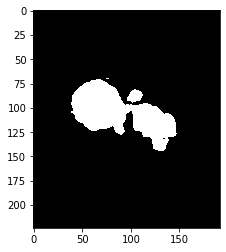

In [23]:
# example image
image = pred_unet_images['dataset6_relu_smoothed6']
plt.imshow(np.squeeze(image[70]), cmap='gray')
plt.show()

In [24]:
# create also the corresponding original/smoothed images and ground truths 
def get_corresponding_data_unet(rootdir, org_images, smoothed_images, gt_images, iternumber): 
    """ Get the original image and the ground truth data of all the U-net models. """
    
    datasets_org = {}
    datasets_gt = {}
    
    # get the modelnames of the #th iteration number
    modelnames = get_modelnames(rootdir, iternumber)
    
    # iterate over the models
    for modelname in modelnames: 
        
        # the input images as original images or smoothed images 
        if 'org' in modelname:
            inputimages = generate_data(org_images)
        elif 'smoothed' in modelname: 
            inputimages = generate_data(smoothed_images)
            
        # the ground truth 
        groundtruth_images = generate_data(gt_images)       
        
        # create the dictionaries
        for datakey, image in inputimages.items():            
            original_image = np.squeeze(image)
            groundtruth_image = np.squeeze(groundtruth_images[datakey])

            # Save images in datasets dictionary
            datasetname = datakey + '_' + modelname.split('_', 2)[-1]
            datasets_org.update({datasetname: original_image})
            datasets_gt.update({datasetname: groundtruth_image})

    print("datasets created")
    return datasets_org, datasets_gt    
    
org_unet_images, gt_unet_images = get_corresponding_data_unet(DATA_UNET_PATH, org_images, smoothed_images, gt_images, iternumber=6)
    

datasets created


In [25]:
# save the data in pickle file
def save_data_pickle(PATH, data, filename, iternumber):
    """ Save data in pickle file. """
    with open(PATH + '/' + filename + str(iternumber) + ".pkl","wb") as f:
        pickle.dump(data,f)
    print(filename, "created")
    

In [26]:
# save the data in numpy arrays (pickle files) for the animations and VTK
save_data_pickle(PATH = RESULTS_UNET_PATH, data = org_unet_images, filename = 'org_unet_images', iternumber=6)
save_data_pickle(PATH = RESULTS_UNET_PATH, data = gt_unet_images, filename = 'gt_unet_images', iternumber=6)
save_data_pickle(PATH = RESULTS_UNET_PATH, data = pred_unet_images, filename = 'pred_unet_images', iternumber=6)

org_unet_images created
gt_unet_images created
pred_unet_images created


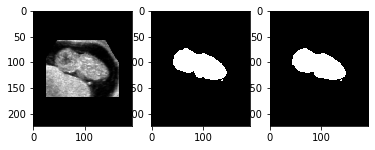

In [27]:
# example
org = org_unet_images['dataset6_relu_smoothed6']
gt = gt_unet_images['dataset6_relu_smoothed6']
pred = pred_unet_images['dataset6_relu_smoothed6']

index = 50
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True)
axs[0].imshow(org[index], cmap='gray')
axs[1].imshow(gt[index], cmap='gray')
axs[2].imshow(pred[index], cmap='gray')
plt.show()

In [28]:
# mask will be always applied to the original image (not the smoothed image) 

In [29]:
org_unet_images.keys()

dict_keys(['dataset1_elu_org6', 'dataset2_elu_org6', 'dataset3_elu_org6', 'dataset4_elu_org6', 'dataset5_elu_org6', 'dataset6_elu_org6', 'dataset7_elu_org6', 'dataset1_elu_smoothed6', 'dataset2_elu_smoothed6', 'dataset3_elu_smoothed6', 'dataset4_elu_smoothed6', 'dataset5_elu_smoothed6', 'dataset6_elu_smoothed6', 'dataset7_elu_smoothed6', 'dataset1_relu_smoothed6', 'dataset2_relu_smoothed6', 'dataset3_relu_smoothed6', 'dataset4_relu_smoothed6', 'dataset5_relu_smoothed6', 'dataset6_relu_smoothed6', 'dataset7_relu_smoothed6'])

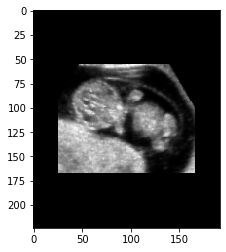

In [30]:
# example image
image = org_unet_images['dataset6_relu_smoothed6']
plt.imshow(np.squeeze(image[70]), cmap='gray')
plt.show()

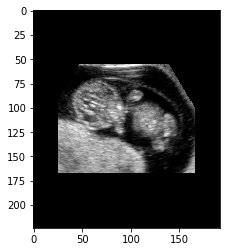

In [31]:
# example image
image = org_unet_images['dataset6_elu_org6']
plt.imshow(np.squeeze(image[70]), cmap='gray')
plt.show()

In [32]:
def get_originalimages(datasets):
    """ Get the original images of all datasets. """
    
    org_dataset = {}
    
    for key, image in datasets.items():
        # get the dataset number and the type of data (org/smoothed)
        datasetname = key.split('_', 1)[0]
        typename = key.split('_')[-1][:-1]
        
        # get the original images of all datasets
        if datasetname not in org_dataset.keys() and typename == 'org': 
            org_dataset.update({datasetname: image})
    
    return org_dataset
        

def generate_invmask_unet(org_datasets, binary_datasets):
    """ Generate the inverted masks. 
        Apply the binary mask over the original image to create an inverted mask. """
    
    inv_datasets = {}
    
    # get of all datasets the original images 
    real_org_datasets = get_originalimages(org_datasets)
 
    # apply the masks over the original images
    for binary_key, binary_image in binary_datasets.items():
        datasetname = binary_key.split('_', 1)[0]
        org_image = real_org_datasets[datasetname]
        image = apply_mask(org_image, binary_image)
        
        # Save images in datasets dictionary
        inv_datasets.update({binary_key: image})
        
    print("datasets created") 
    return inv_datasets

# inverted u-net mask over original images and smoothed images
inv_pred_unet_images = generate_invmask_unet(org_unet_images, pred_unet_images)

datasets created


In [33]:
# inverted mask of ground truth mask over original images and smoothed images
inv_gt_unet_images = generate_invmask_unet(org_unet_images, gt_unet_images)

datasets created


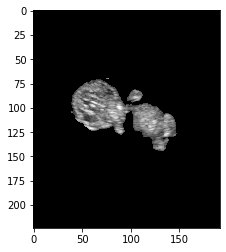

In [34]:
# example image
image = inv_pred_unet_images['dataset6_relu_smoothed6']
plt.imshow(np.squeeze(image[70]), cmap='gray')
plt.show()

In [35]:
# Because a padding has been added to the original/smoothed and ground truth image, 
# These images are additionally saved for exposure render
RESULTS_UNET_EXP_ORG_PATH = RESULTS_UNET_PATH + '/exposure_render/org' 
RESULTS_UNET_EXP_GT_PATH = RESULTS_UNET_PATH + '/exposure_render/gt' 
RESULTS_UNET_EXP_PRED_PATH = RESULTS_UNET_PATH + '/exposure_render/pred' 

create_dir(RESULTS_UNET_EXP_ORG_PATH)
create_dir(RESULTS_UNET_EXP_GT_PATH)
create_dir(RESULTS_UNET_EXP_PRED_PATH)

Directory results_volumes\results_volumes_convert\convert_unet/exposure_render/org created
Directory results_volumes\results_volumes_convert\convert_unet/exposure_render/gt created
Directory results_volumes\results_volumes_convert\convert_unet/exposure_render/pred created


In [36]:
def convert_unet_mhd(datasets, savedir):
    """ Save the numpy images to .mhd file for exposure render. """
    
    print('Convert ' + str(len(datasets)) + ' datasets')
    for datakey, values in datasets.items():
        # convert numpy array to sitk image
        image =  sitk.GetImageFromArray(values)
        
        # write the file
        writer = sitk.ImageFileWriter()
        writer.SetFileName(savedir + '/' +  datakey + '.mhd')
        writer.Execute(image)


In [37]:
# convert the predictions 
convert_unet_mhd(datasets = org_unet_images, savedir = RESULTS_UNET_EXP_ORG_PATH)
convert_unet_mhd(datasets = inv_gt_unet_images, savedir = RESULTS_UNET_EXP_GT_PATH)
convert_unet_mhd(datasets = inv_pred_unet_images, savedir = RESULTS_UNET_EXP_PRED_PATH)

Convert 21 datasets
Convert 21 datasets
Convert 21 datasets


In [38]:
# Because a padding has been added to the original/smoothed and ground truth image, 
# These images are additionally saved for volume viewer
RESULTS_UNET_VV_ORG_PATH = RESULTS_UNET_PATH + '/volume_viewer/org' 
RESULTS_UNET_VV_GT_PATH = RESULTS_UNET_PATH + '/volume_viewer/gt' 
RESULTS_UNET_VV_PRED_PATH = RESULTS_UNET_PATH + '/volume_viewer/pred'

create_dir(RESULTS_UNET_VV_ORG_PATH)
create_dir(RESULTS_UNET_VV_GT_PATH)
create_dir(RESULTS_UNET_VV_PRED_PATH)

Directory results_volumes\results_volumes_convert\convert_unet/volume_viewer/org created
Directory results_volumes\results_volumes_convert\convert_unet/volume_viewer/gt created
Directory results_volumes\results_volumes_convert\convert_unet/volume_viewer/pred created


In [39]:
def convert_unet_vtk(datasets, savedir):
    """ Save the numpy images to .vtk file for eventually showing in volume viewer.
        Additionally, the files are in Volview manually saved as a .vti file.
        This .vti file can be read in volume viewer. """

    print('Convert ' + str(len(datasets)) + ' datasets')
    for datakey, values in datasets.items():
        # convert numpy array to sitk image
        image =  sitk.GetImageFromArray(values)
        
        # write the file
        writer = sitk.ImageFileWriter()
        writer.SetFileName(savedir + '/' +  datakey + '.vtk')
        writer.Execute(image)
        

In [40]:
convert_unet_vtk(datasets = org_unet_images, savedir = RESULTS_UNET_VV_ORG_PATH)
convert_unet_vtk(datasets = inv_gt_unet_images, savedir = RESULTS_UNET_VV_GT_PATH)
convert_unet_vtk(datasets = inv_pred_unet_images, savedir = RESULTS_UNET_VV_PRED_PATH)

Convert 21 datasets
Convert 21 datasets
Convert 21 datasets
